In [23]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)

RANDOM_STATE = 42 # for reproducibility

### Baseline Logistic Regression
- This includes the cleaning pieces (drop leakage, drop missing target, imputation, encoding, scaling), plus a stratified split and evaluation for classification.

In [2]:
# 1. loading dataset
df = pd.read_csv("../dataset/THP_clean.csv")

In [3]:
# show all columns & allow many rows when printing summaries
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)   # set to a number >= your column count or use None (be careful with using 'None')

In [ ]:
df.head(20)

In [ ]:
# Very quick overview
df.info(verbose=True, show_counts=True)

In [ ]:
# absolutely everything printed once
print(df.isnull().sum().to_string())

In [7]:
# get all column names containing 'depressed'
depressed_cols = [col for col in df.columns if "depressed" in col.lower()]
print(depressed_cols)

['depressed_6m', 'depressed_1y', 'depressed', 'notdepressed']


In [8]:
# 2. set target and drop rows with missing target
target = "depressed_6m" # NOTE: change this to "depressed_1y" when needed 
# if 'depressed' is used, the model overfits
df = df.dropna(subset=[target])

In [9]:
# 3. drop leakage columns (anything with '6m' or '1y' in the name) + target itself
leak_cols = [c for c in df.columns if ("6m" in c.lower()) or ("1y" in c.lower())]
leak_cols = list(set(leak_cols) - {target})   # ensure target not accidentally dropped
df = df.drop(columns=leak_cols, errors="ignore")

In [10]:
# 4. drop unnecessary columns
df = df.drop(columns=["newid", "interviewer"], errors="ignore")

In [11]:
# 5. X / y
# X - feature
# y - target
X = df.drop(columns=[target])
y = df[target]

In [12]:
# 6. quick check: make sure y is binary 0/1 (or map it)
print("y unique values:", pd.Series(y).unique())
# If y is boolean or strings, convert to 0/1, e.g.
# y = y.map({False:0, True:1})  # or map({"No":0,"Yes":1}) depending on actual values

# convert to int if numeric-like floats
try:
    y = y.astype(int)
except:
    pass

y unique values: [0. 1.]


In [13]:
# 7. inspect class balance
print("Class distribution:\n", y.value_counts(normalize=True))

Class distribution:
 depressed_6m
0    0.623472
1    0.376528
Name: proportion, dtype: float64


In [14]:
# 8. split (STRATIFY to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    # using 'stratify=y' so the test set keeps the same class proportion.
)

In [15]:
# 9. detect numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("num_cols:", len(num_cols), "cat_cols:", len(cat_cols))

num_cols: 331 cat_cols: 17


In [16]:
# 10. build preprocessing pipelines
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
    # StandardScaler is important because logistic regularization depends on feature scale.
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="drop")

In [17]:
# 11. create full pipeline with LogisticRegression
clf = Pipeline([
    ("preproc", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="liblinear"))
])

In [18]:
# 12. fit baseline logistic model
clf.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['uc', 'income_mo',
                                                   'income_hh', 'edu_mo',
                                                   'edu_fa',
                                                   'no_kids_over5_dead',
                                                   'no_kids_1_5_dead',
                                                   'no_kids_less1_dead', 'c_wt',
                                                   'c_ht', 'mo_ht', 'mo_bmi',
                                                   'hamd_baseline',
                                                   'bdq_baseline',
                                                   'edu_mo_baseline',
                                                   'edu_f...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['grandmother', 'employed_mo',
                                                   'genhealth', 'ideal_no_kids',
                                                   'mo_185', 'mo_358', 'mo_360',
                                                   'ch_27', 'ch_28', 'ch_29',
                                                   'ch_30', 'ch_31', 'ch_32',
                                                   'ch_33', 'ch_34', 'ch_35',
                                                   'ch_36'])])),
                ('model',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [19]:
# 13. predict and probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability of class 1

In [20]:
# 14. evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("Baseline Logistic Regression")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)
print("ROC AUC:", roc_auc)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Baseline Logistic Regression
Accuracy: 0.9024390243902439
Precision: 0.8709677419354839
Recall: 0.8709677419354839
F1: 0.8709677419354839
ROC AUC: 0.9696394686907022

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       102
           1       0.87      0.87      0.87        62

    accuracy                           0.90       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.90      0.90      0.90       164

Confusion matrix:
 [[94  8]
 [ 8 54]]


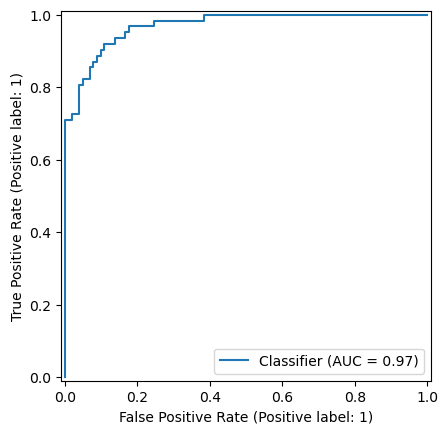

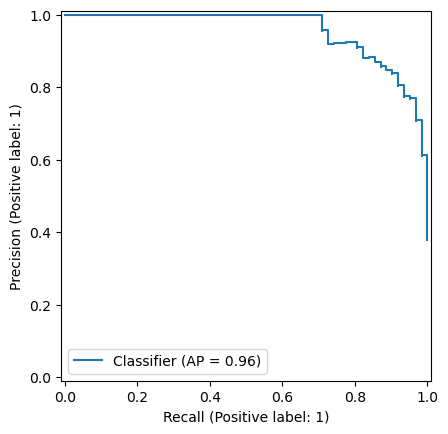

In [21]:
# 15. ROC & PR curves (visual)
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

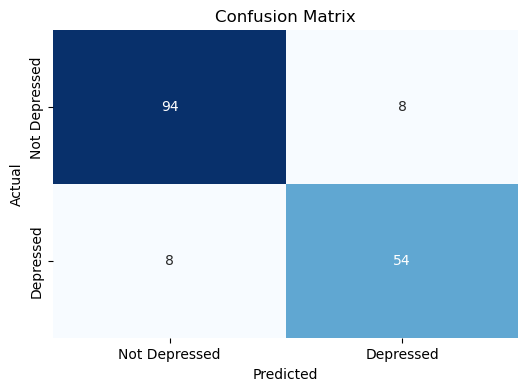

In [24]:
# plot confusion matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Feature importance (coefficients); a quick extraction
- This gives the top positive and negative contributors to predicted probability (after scaling).
- Positive coefficient → increases probability of depression.

In [26]:
# get feature names after preprocessing
feature_names = clf.named_steps["preproc"].get_feature_names_out()
coef = clf.named_steps["model"].coef_.flatten()

feat_coef = pd.DataFrame({"feature": feature_names, "coef": coef})
feat_coef["abs_coef"] = feat_coef["coef"].abs()
feat_coef = feat_coef.sort_values("abs_coef", ascending=False)
feat_coef.head(30)

,feature,coef,abs_coef
319,num__depression_traj,2.652869,2.652869
320,num__depression_traj_f,2.198972,2.198972
321,num__depression_traj_all,1.764835,1.764835
159,num__recover_perm,1.353860,1.353860
322,num__depression_traj_all_f,1.197322,1.197322
160,num__recover_never,-0.718964,0.718964
305,num__relation_traj,0.609234,0.609234
86,num__lhw_18,-0.511972,0.511972
297,num__motherhealthindex,0.509174,0.509174
77,num__lhw_9,0.477123,0.477123


### Hyperparameter tuning for Logistic Regression

In [27]:
param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

best_model = grid.best_estimator_
y_proba_best = best_model.predict_proba(X_test)[:,1]
print("Test ROC AUC (best):", roc_auc_score(y_test, y_proba_best))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'model__C': 1, 'model__class_weight': 'balanced'}
Best CV ROC AUC: 0.9710773863294188
Test ROC AUC (best): 0.9696394686907022


### Threshold Tuning
- By default, sklearn uses 0.5 as the cutoff → if p ≥ 0.5, predict 1, else 0.
- But that threshold may not always be the best for our use case:
    - If false negatives are costly (e.g., missing a depressed patient), lower the threshold (e.g., 0.3) to catch more positives (↑ recall).
    - If false positives are costly (e.g., wrongly diagnosing healthy people), raise the threshold (e.g., 0.7) to avoid overdiagnosis (↑ precision).
- This is the importance of THRESHOLD TUNING

In [28]:
# 1. Get probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

In [29]:
# 2. Loop through thresholds and calculate metrics
thresholds = np.linspace(0, 1, 101)
precisions, recalls, f1s = [], [], [] # save as lists

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_t, zero_division=0))

In [30]:
# This way, above, we’ll still get curves that show:
# Precision starts high, then drops as the threshold is lowered.
# Recall starts low, then rises as the threshold is lowered.
# F1 peaks somewhere in between (the balanced point/the sweet spot)

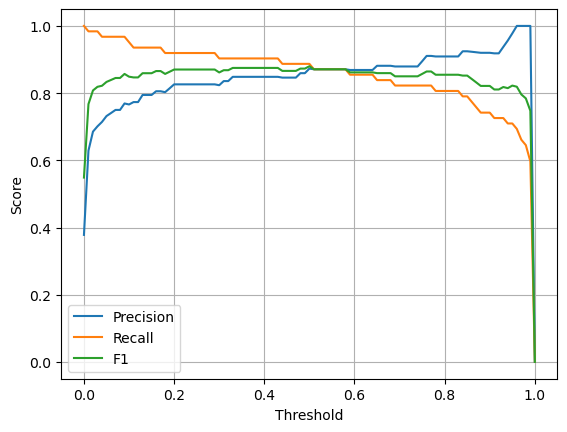

In [31]:
# 3. Plot Precision-Recall vs Threshold
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# I only collected precisions, recalls, and f1s as lists.
# Now, putting everything together into a dataframe - metrics_df
metrics_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precisions,
    "recall": recalls,
    "f1": f1s
})

In [33]:
# 4. Pick the threshold
# Maximize F1 (balanced choice)
# maximizing F1 is the standard when both false positives and false negatives are costly, 
# and the desire is to build a balanced classifier

best_row = metrics_df.loc[metrics_df['f1'].idxmax()]
print("Best threshold:", best_row['threshold'])
print("Precision:", best_row['precision'])
print("Recall:", best_row['recall'])
print("F1:", best_row['f1'])

Best threshold: 0.5
Precision: 0.873015873015873
Recall: 0.8870967741935484
F1: 0.88


In [34]:
# 5. Finalize model with chosen/best threshold
best_threshold = best_row['threshold']
def tuned_predict(X):
    return (best_model.predict_proba(X)[:, 1] >= best_threshold).astype(int)

In [35]:
# 6. recalculating classification report and confusion matrix after tuning
y_pred_tuned = tuned_predict(X_test)

print("Classification report (tuned threshold):")
print(classification_report(y_test, y_pred_tuned))

print("Confusion matrix (tuned threshold):")
print(confusion_matrix(y_test, y_pred_tuned))

Classification report (tuned threshold):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       102
           1       0.87      0.89      0.88        62

    accuracy                           0.91       164
   macro avg       0.90      0.90      0.90       164
weighted avg       0.91      0.91      0.91       164

Confusion matrix (tuned threshold):
[[94  8]
 [ 7 55]]


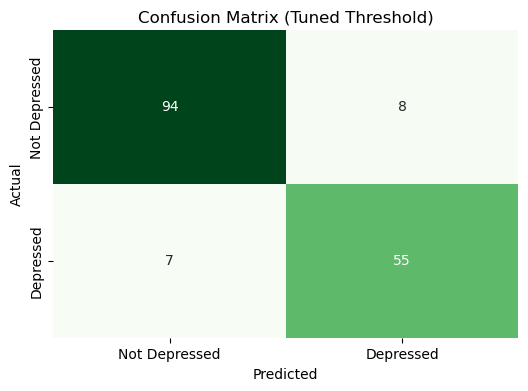

In [36]:
# Confusion matrix for tuned threshold
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Not Depressed", "Depressed"],
            yticklabels=["Not Depressed", "Depressed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned Threshold)")
plt.show()

In [37]:
# a safe check to know if the right target is being used
# target can be set to 'depressed_6m', 'depressed_1y' 
# using 'depressed' as target overfits the model
print(y.name)

depressed_6m


### Saving the Model in Best State
Since threshold tuning doesn’t change the underlying model, I save:
- The trained model (best_model)
- The chosen threshold (so we remember the decision rule later)

In [38]:
# save model + threshold as a dictionary
# joblib.dump({
#     "model": best_model,
#     "threshold": best_threshold
# }, "logreg_best_with_threshold.pkl")

# This saves the best hyperparameter-tuned model (not the baseline).
# It also saves the best threshold found from threshold tuning.

### Loading up the saved model for later use

In [39]:
# load later
# we’ll get both the tuned model and the threshold.
# saved = joblib.load("logreg_best_with_threshold.pkl")
# loaded_model = saved["model"]
# loaded_threshold = saved["threshold"]